In this notebook, I'm going to attempt a new tack for my analysis. 

In [487]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

## What is the distribution of the maximum and minimum IMAE per protein?

In [488]:
df = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t')

df = df.rename(columns={'2_comp': 'IMAE'})
df.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,conformation,organism,date,notes,chain,af_filename
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,Closed,"""Homo sapiens""",['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,Closed,"""Neurospora crassa""",['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,Closed,"""Neurospora crassa""",['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif


In [489]:
# Find the max and min IMAE per protein and create a new dataframe with the difference between those two values
df_max = df.groupby('uniprot')['IMAE'].max().reset_index()
df_min = df.groupby('uniprot')['IMAE'].min().reset_index().drop_duplicates(keep='first')
df_diff = pd.merge(df_max, df_min, on='uniprot')
df_diff['diff'] = df_diff['IMAE_x'] - df_diff['IMAE_y']
df_diff = df_diff.sort_values('diff', ascending=False)
df_diff.head()

,uniprot,IMAE_x,IMAE_y,diff
107,Q96P20,80.422,6.447,73.975
62,Q00944,71.123,1.906,69.217
66,Q06124,58.638,0.770,57.868
35,P29350,57.427,1.765,55.662
5,O08967,54.034,1.593,52.441


Now that we've seen the distribution (deleted), how many proteins do we have with differences greater than 3? We use 3 as our cutoff because that's the "crystallographic" cutoff, if you will.

We know from some data wrangling (that we have now deleted) that there's a pretty heavy overlap between the proteins with both active and autoinhibitory states and our proteins. So, we're going to focus on the two max and min structures per protein.

In [491]:
# What are the state and conformation annotations for these proteins?
df_smol = df_diff[['uniprot', 'diff']]
df_max = pd.merge(df, df_max, on=['uniprot', 'IMAE'])
df_min = pd.merge(df, df_min, on=['uniprot', 'IMAE'])
bounds = pd.concat([df_max, df_min])
df = pd.merge(df, df_smol, on='uniprot')
g3 = pd.merge(bounds, df_smol, on='uniprot')

g3.shape

(259, 17)

In [492]:
# Create a new columns, num_states, that is the number of states per protein
val_counts = df.groupby('uniprot')['state'].nunique().reset_index()
val_counts = val_counts.rename(columns={'state': 'num_states'})
df = pd.merge(df, val_counts, on='uniprot')

In [493]:
# Create a new column, num_confs, that is the number of conformations per protein
val_counts = df.groupby('uniprot')['conformation'].nunique().reset_index()
val_counts = val_counts.rename(columns={'conformation': 'num_confs'})
df = pd.merge(df, val_counts, on='uniprot')
s_c = df[['uniprot', 'num_states', 'num_confs']].drop_duplicates()

In [494]:
g3 = pd.merge(g3, s_c, on='uniprot', how='left')
g3.shape

(259, 19)

In [495]:
# How many proteins do we have with a difference greater than 3? How about ten?

# Greater than 3
g3 = g3[g3['diff'] > 3]
print('The number of proteins with a difference between min and max IMAE greater than 3 is ' + str(g3['uniprot'].nunique()))
print('The number of structures with no annotated state in this group is: ' + str(g3['state'].isnull().sum()))

The number of proteins with a difference between min and max IMAE greater than 3 is 29
The number of structures with no annotated state in this group is: 12


In [496]:
# How many proteins do we have with a difference greater than 3 and 0 states?
not_an = df[(df['diff'] > 3) & (df['num_states'] == 0)]
print(not_an['uniprot'].unique())

['Q6SZW1' 'Q9JK66']


In [525]:
# For those proteins with differences greater than 3, what are the state and conformation annotations?
grouped = g3.groupby('uniprot')['state'].value_counts()
grouped


uniprot     state        
A0A0R4I961  Active           2
O00571      Active           1
            Autoinhibited    1
O08967      Active           1
            Autoinhibited    1
P00579      Active           2
P07038      Autoinhibited    2
            Active           1
P12931      Active           1
            Autoinhibited    1
P21333      Active           1
            Autoinhibited    1
P22681      Active           1
            Autoinhibited    1
P26358      Active           1
            Autoinhibited    1
P27577      Active           1
            Autoinhibited    1
P28482      Active           1
            Autoinhibited    1
P29350      Active           1
            Autoinhibited    1
P35520      Active           1
            Autoinhibited    1
P49137      Autoinhibited    1
P53041      Active           2
P53042      Active           1
            Autoinhibited    1
P54646      Active           2
P60240      Active           1
            Autoinhibited    1
P62826      A

In [498]:
nan = g3[g3['state'].isnull()]
nan.head(15)

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,conformation,organism,date,notes,chain,af_filename,diff,num_states,num_confs
32,Q9UM73,2xb7,"1279-1288,1158-1173","1116-1157,1174-1278,1289-1392",1.069,61.538462,95.617530,1.020,1.022,NaN,Closed,HOMO SAPIENS,['2010-04-08'],NaN,A,F-Q9UM73-F1-model_v3.cif,6.189,1,1
33,Q06124,6crf,3-104,247-517,20.036,96.078431,95.571956,1.116,58.638,NaN,Closed,Homo sapiens,['2018-03-17'],NaN,A,F-Q06124-F1-model_v3.cif,57.868,1,1
34,Q06124,6mdc,3-104,247-517,1.132,88.235294,97.416974,1.203,0.770,NaN,Closed,Homo sapiens,['2018-09-04'],NaN,A,F-Q06124-F1-model_v3.cif,57.868,1,1
39,Q96FI4,6lwk,244-245,220-280,1.734,100.000000,91.803279,3.223,11.780,NaN,Closed,Homo sapiens,['2020-02-07'],NaN,A,F-Q96FI4-F1-model_v3.cif,11.376,1,1
71,Q6SZW1,7knq,"560-703,382-385,375-399,281-331","244-269,134-173,162-197,402-476,412-484",22.242,91.818182,100.000000,2.528,52.996,NaN,Closed,Homo sapiens,['2020-11-05'],NaN,A,F-Q6SZW1-F1-model_v3.cif,50.048,0,1
72,Q6SZW1,7cm6,"560-703,382-385,375-399,281-331","244-269,134-173,162-197,402-476,412-484",1.709,90.909091,100.000000,1.016,2.948,NaN,Closed,Homo sapiens,['2020-07-25'],NaN,A,F-Q6SZW1-F1-model_v3.cif,50.048,0,1
80,Q9UGN5,4pjv,231-348,356-538,0.968,94.067797,99.453552,0.911,1.118,NaN,Closed,Homo sapiens,['2014-05-12'],NaN,A,F-Q9UGN5-F1-model_v3.cif,17.089,1,1
129,Q96P20,7vtp,740-991,220-536,22.263,100.000000,94.637224,14.386,80.422,NaN,Open,Homo sapiens,['2021-10-30'],NaN,A,F-Q96P20-F1-model_v3.cif,73.975,1,1
130,Q96P20,8ej4,740-991,220-536,4.759,100.000000,100.000000,1.857,6.447,NaN,Open,Homo sapiens,['2022-09-16'],NaN,A,F-Q96P20-F1-model_v3.cif,73.975,1,1
187,P49137,8xu4,328-364,64-325,3.702,64.864865,93.511450,3.659,4.961,NaN,Closed,Homo sapiens,NaN,NaN,A,F-P49137-F1-model_v3.cif,3.734,1,1


We have 17 proteins with two annotated states, 10 proteins with 1 annotated state, and 2 proteins with 0 annotated states. 

## Analyzing our Proteins of Interest with DockQ

In [499]:
dq = pd.read_csv('./project_pipeline/data/ai_pdb_full_depth_dockq.csv')

In [500]:
g3d = pd.merge(g3, dq, on=['uniprot', 'pdb'])
g3d.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,fnat,fnat_correct,fnat_total,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri
0,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.235,12.0,51.0,0.250,4.0,16.0,13.218,28.907,0.109,Incorrect
1,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,0.200,9.0,45.0,0.308,4.0,13.0,5.585,14.400,0.175,Incorrect
2,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,0.200,9.0,45.0,0.308,4.0,13.0,5.585,14.400,0.175,Incorrect
3,Q8NQJ3,2kb4,1-40,68-117,30.770,100.0,100.0,2.450,61.982,Active,...,0.700,7.0,10.0,0.364,4.0,11.0,6.889,59.886,0.255,Acceptable
4,Q8NQJ3,2kb3,1-40,68-117,15.371,97.5,100.0,2.552,29.829,Autoinhibited,...,0.088,6.0,68.0,0.455,5.0,11.0,13.622,28.393,0.061,Incorrect


## Compare with Multi-Domain proteins

In [501]:
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t')

md = md.rename(columns={'2_comp': 'IMAE'})
md.head()

,uniprot,pdb,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,1.1_comp,1.2_aligned,1.2_comp,2.0_aligned,...,percent_region_1,percent_region_2,chain,gt_fn,af_filename,complex_fn,1_aligned,1_comp,2_aligned,IMAE
0,D9N168,3ht3,1.115,0.883,1.265,0.0,0.0,0.0,0.0,1.153,...,100.0,100.000000,A,3ht3.cif,AF-D9N168-F1-model_v4.cif,data/output/complexes/3ht3_D9N168.pdb,0.883,1.265,1.153,0.979
1,D9N168,4o0i,1.166,0.826,1.400,0.0,0.0,0.0,0.0,1.253,...,100.0,99.519231,A,4o0i.cif,AF-D9N168-F1-model_v4.cif,data/output/complexes/4o0i_D9N168.pdb,0.826,1.400,1.253,0.999
2,D9N168,6ueu,1.787,0.720,2.800,0.0,0.0,0.0,0.0,2.667,...,100.0,99.038462,A,6ueu.cif,AF-D9N168-F1-model_v4.cif,data/output/complexes/6ueu_D9N168.pdb,0.720,2.800,2.667,1.017
3,D9N168,6ur2,1.208,0.836,1.554,0.0,0.0,0.0,0.0,1.317,...,100.0,99.519231,A,6ur2.cif,AF-D9N168-F1-model_v4.cif,data/output/complexes/6ur2_D9N168.pdb,0.836,1.554,1.317,0.998
4,D9N168,6ur4,1.208,0.842,1.584,0.0,0.0,0.0,0.0,1.275,...,100.0,99.519231,A,6ur4.cif,AF-D9N168-F1-model_v4.cif,data/output/complexes/6ur4_D9N168.pdb,0.842,1.584,1.275,1.073


In [502]:
md_nums = md['uniprot'].value_counts()
multi_md = md_nums[md_nums > 1].index

df_nums = df['uniprot'].value_counts()
multi_df = df_nums[df_nums > 1].index

In [503]:
# Find the max and min IMAE per protein and create a new dataframe with the difference between those two values
md_max = md.groupby('uniprot')['IMAE'].max().reset_index()
md_min = md.groupby('uniprot')['IMAE'].min().reset_index().drop_duplicates(keep='first')
md_diff = pd.merge(md_max, md_min, on='uniprot')
md_diff['diff'] = md_diff['IMAE_x'] - md_diff['IMAE_y']
md_diff.head()

,uniprot,IMAE_x,IMAE_y,diff
0,A0A0A0V031,59.293,0.755,58.538
1,A0A0F7R6G7,59.777,6.903,52.874
2,A0A0H2WY27,1.909,1.038,0.871
3,A0A140DJY3,2.846,2.581,0.265
4,A0A3B6UEQ0,0.891,0.891,0.000


Text(0.5, 0, 'Difference between max and min IMAE')

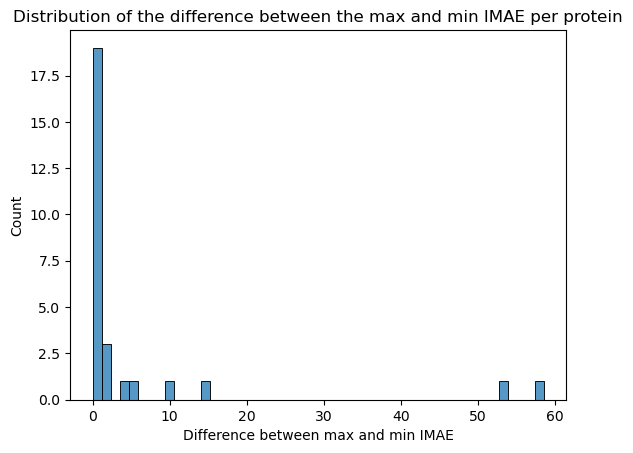

In [504]:
not_zero = md_diff[md_diff['diff'] != 0]

fig, ax = plt.subplots()
sns.histplot(not_zero['diff'], bins=50)
ax.set_title('Distribution of the difference between the max and min IMAE per protein')
ax.set_xlabel('Difference between max and min IMAE')

We can compare the two in a boxplot


In [505]:
df_diff['type'] = 'Autoinhibitory'
md_diff['type'] = 'Multi-domain'


# Keep only proteins with multiple structures. Having proteins with only one structure renders the comparison moot.
md_diff = md_diff[md_diff['uniprot'].isin(multi_md)]
df_diff = df_diff[df_diff['uniprot'].isin(multi_df)]


diffs = pd.concat([df_diff, md_diff])
diffs['type'].value_counts()

Autoinhibitory    71
Multi-domain      28
Name: type, dtype: int64

(0.0, 20.0)

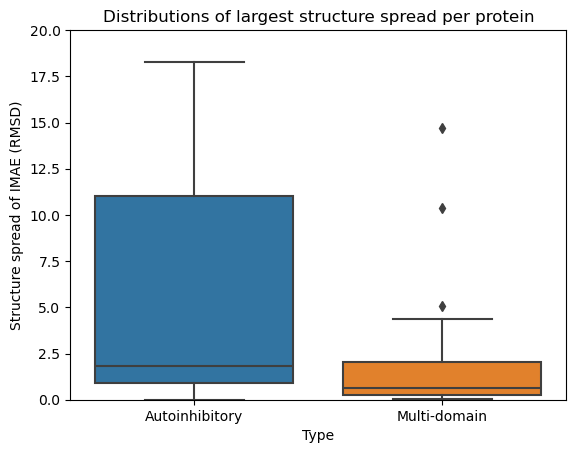

In [506]:
fig, ax = plt.subplots()
sns.boxplot(data=diffs, x='type', y='diff')
ax.set_title('Distributions of largest structure spread per protein')
ax.set_xlabel('Type')
ax.set_ylabel('Structure spread of IMAE (RMSD)')
ax.set_ylim(0, 20)

## How many "conformations" are there per protein?

In [507]:
def assign_bins(df, bin_size=3):
    '''
    Assigns bins to the IMAE values of the dataframe, based on the bin_size provided.
    '''
    bins_info = []

    for protein in df['uniprot'].unique():
        protein_df = df[df['uniprot'] == protein]
        min_val = protein_df['IMAE'].min()
        max_val = protein_df['IMAE'].max()
        bins = np.arange(min_val, max_val + bin_size, bin_size)
        labels = range(len(bins) - 1)

        protein_df['bin'] = pd.cut(protein_df['IMAE'], bins=bins, labels=labels, include_lowest=True)
        protein_df['bin_id'] = protein + '_' + protein_df['bin'].astype('str')

        bins_info.append(protein_df)

    return pd.concat(bins_info)

In [508]:
# We're only concerned with those proteins with multiple structures
ai_df2 = df[df['uniprot'].isin(multi_df)]
md_df2 = md[md['uniprot'].isin(multi_md)]

ai_df2['type'] = 'Autoinhibitory'
md_df2 = pd.merge(md_df2, md_diff[['uniprot', 'diff', 'type']], on='uniprot')

# Assign bins to the dataframes
ai_df2 = assign_bins(ai_df2)
md_df2 = assign_bins(md_df2)

# Get rid of unnecessary columns in md_df2
md_df2 = md_df2[['uniprot', 'pdb', 'complex_rmsd', 'region_1', 'region_2', 'percent_region_1', 'percent_region_2',
                '2_aligned', 'IMAE', 'type', 'bin', 'bin_id']]

# Concatenate the dataframes
all_df = pd.concat([ai_df2, md_df2])
all_df.head()

/tmp/ipykernel_1154632/2495169099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df2['type'] = 'Autoinhibitory'
/tmp/ipykernel_1154632/4153892630.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  protein_df['bin'] = pd.cut(protein_df['IMAE'], bins=bins, labels=labels, include_lowest=True)
/tmp/ipykernel_1154632/4153892630.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,date,notes,chain,af_filename,diff,num_states,num_confs,type,bin,bin_id
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,0.000,1.0,1.0,Autoinhibitory,NaN,P04637_nan
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,['2022-11-08'],NaN,A,F-P04637-F1-model_v3.cif,0.000,1.0,1.0,Autoinhibitory,NaN,P04637_nan
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,['2002-08-21'],NaN,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,3.0,P07038_3
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,['2021-03-18'],“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,0.0,P07038_0
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,['2021-03-19'],NaN,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,0.0,P07038_0


In [509]:
# Find the max number of bins per protein
max_bins = all_df.groupby('uniprot')['bin'].max().reset_index()
max_bins = max_bins.rename(columns={'bin': 'max_bin'})

# Merge the max_bins with all_df
all_df = pd.merge(all_df, max_bins, on='uniprot')
all_df.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,notes,chain,af_filename,diff,num_states,num_confs,type,bin,bin_id,max_bin
0,P04637,8f2h,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,NaN,A,F-P04637-F1-model_v3.cif,0.000,1.0,1.0,Autoinhibitory,NaN,P04637_nan,NaN
1,P04637,8f2i,364-393,102-292,30.431,100.0,100.0,3.065,70.729,Autoinhibited,...,NaN,A,F-P04637-F1-model_v3.cif,0.000,1.0,1.0,Autoinhibitory,NaN,P04637_nan,NaN
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,NaN,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,3.0,P07038_3,3.0
3,P07038,7nxf,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,“Phosphorylation of Ser913/Thr914 would distur...,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,0.0,P07038_0,3.0
4,P07038,7ny1,892-917,562-625,4.914,100.0,100.0,1.812,12.107,Autoinhibited,...,NaN,A,F-P07038-F1-model_v3.cif,10.708,2.0,1.0,Autoinhibitory,0.0,P07038_0,3.0


Text(0, 0.5, 'Number of distinct conformations')

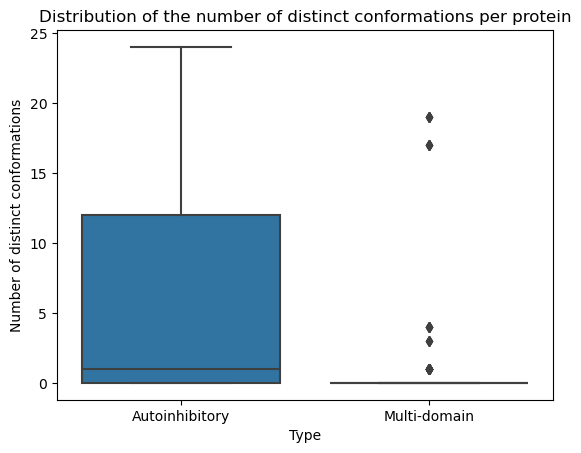

In [510]:
to_plot = all_df[['uniprot', 'type', 'max_bin']].drop_duplicates().reset_index(drop=True)

fig, ax = plt.subplots()
sns.boxplot(data=all_df, x='type', y='max_bin')
ax.set_title('Distribution of the number of distinct conformations per protein')
ax.set_xlabel('Type')
ax.set_ylabel('Number of distinct conformations')

In [511]:
to_plot['type'].value_counts()

Autoinhibitory    71
Multi-domain      28
Name: type, dtype: int64

## How many interface contacts does each of our important structures above have?

In [512]:
ifc = pd.read_csv('./project_pipeline/data/proteins_interface.tsv', sep='\t')
ifc = ifc[['uniprot', 'pdb', 'number_interface_residues']]
ifc.head()

,uniprot,pdb,number_interface_residues
0,P04637,8f2h,21.0
1,P04637,8f2i,21.0
2,P00523,2ptk,33.0
3,P28482,1pme,70.0
4,P28482,1tvo,68.0


In [513]:
df2 = pd.merge(g3d, ifc, on=['uniprot', 'pdb'])
df2 = df2[['uniprot', 'pdb', 'complex_rmsd', 'IMAE', 'state', 'conformation', 'fnat', 'fnat_total', 'fnonnat', 'dockq', 'capri', 'number_interface_residues']]
df2['number_interface_residues'] = df2['number_interface_residues'].astype('float')
df2['number_interface_residues'] = df2['number_interface_residues'].fillna(0)
df2['IMAE'] = df2['IMAE'].astype('float')
df2

,uniprot,pdb,complex_rmsd,IMAE,state,conformation,fnat,fnat_total,fnonnat,dockq,capri,number_interface_residues
0,P07038,1mhs,14.225,22.815,Active,Closed,0.235,51.0,0.250,0.109,Incorrect,18.0
1,P07038,7nxf,4.914,12.107,Autoinhibited,Closed,0.200,45.0,0.308,0.175,Incorrect,26.0
2,P07038,7ny1,4.914,12.107,Autoinhibited,Closed,0.200,45.0,0.308,0.175,Incorrect,26.0
3,Q8NQJ3,2kb4,30.770,61.982,Active,Open,0.700,10.0,0.364,0.255,Acceptable,0.0
4,Q8NQJ3,2kb3,15.371,29.829,Autoinhibited,Closed,0.088,68.0,0.455,0.061,Incorrect,37.0
5,P60240,4s20,11.120,29.595,Autoinhibited,Closed,0.147,34.0,0.853,0.078,Incorrect,22.0
6,P60240,7m8e,5.106,11.303,Active,Open,0.609,23.0,0.588,0.478,Acceptable,0.0
7,A0A0R4I961,6gu0,2.105,4.298,Active,Closed,0.986,69.0,0.056,0.909,High,40.0
8,A0A0R4I961,6gtv,1.450,1.135,Active,Closed,0.957,69.0,0.083,0.934,High,39.0
9,P00579,7khi,18.080,51.763,Active,Open,0.400,25.0,0.333,0.162,Incorrect,0.0


In [514]:
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['number_interface_residues'], data['IMAE'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

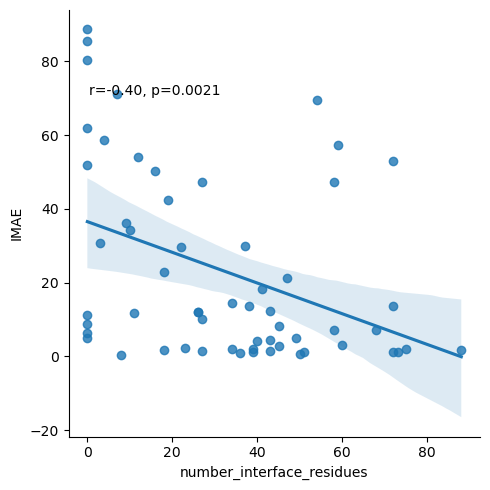

In [515]:
g = sns.lmplot(data=df2, x='number_interface_residues', y='IMAE')

g.map_dataframe(annotate)

<Axes: xlabel='capri', ylabel='IMAE'>

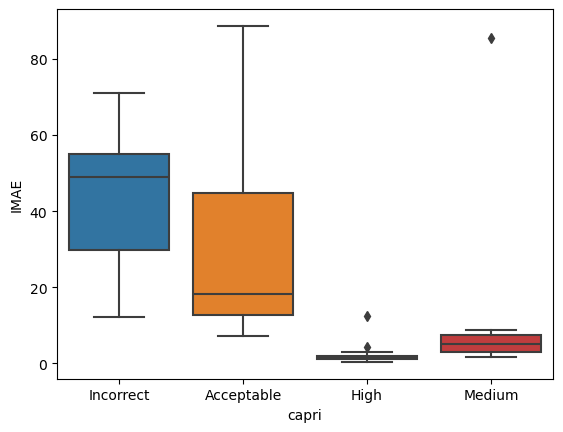

In [516]:
sns.boxplot(data=df2, x='capri', y='IMAE')

Based on this, it would be smart to use the structures with the most interface contacts as the "native" in a DockQ analysis, with the exception of those proteins that have no structures in the closed conformation. In that case, use the one with the lowest IMAE.

## How well does AlphaFold2 perform?

How many structures does AlphaFold2 match to within 3 Angstroms?

In [517]:
best_alpha = g3d[g3d['complex_rmsd'] <= 3]
best_alpha['uniprot'].nunique()

18

In [533]:
best_alpha['state'].value_counts()

Active           9
Autoinhibited    7
Name: state, dtype: int64

In [530]:
best_uniprots = best_alpha['uniprot'].unique()
best = g3d[g3d['uniprot'].isin(best_uniprots)]
best.groupby('uniprot')['state'].value_counts()

uniprot     state        
A0A0R4I961  Active           2
O00571      Active           1
            Autoinhibited    1
P12931      Active           1
            Autoinhibited    1
P22681      Active           1
            Autoinhibited    1
P26358      Active           1
            Autoinhibited    1
P28482      Active           1
            Autoinhibited    1
P29350      Active           1
            Autoinhibited    1
P49137      Autoinhibited    1
P53042      Active           1
            Autoinhibited    1
P54646      Active           2
Q00944      Active           1
            Autoinhibited    1
Q96FI4      Active           1
Q9UGN5      Active           1
Q9UM73      Autoinhibited    1
Q9Y6K1      Active           1
            Autoinhibited    1
Name: state, dtype: int64

16 proteins. Not too bad.

Of all of our proteins, how many does AlphaFold2 match to within 3 angstroms?

In [518]:
best_all = df[df['complex_rmsd'] <= 3]
best_all['uniprot'].nunique()

75

Of our multi-domain proteins, how many does AlphaFold2 match to within 3 angstroms?

In [519]:
md_best = md[md['complex_rmsd'] <= 3]
print('The number of good fits for multi_domain proteins is ' + str(md_best['uniprot'].nunique()) + ' out of ' + str(md['uniprot'].nunique()) + ' proteins.')


The number of good fits for multi_domain proteins is 31 out of 40 proteins.


How many protein structures does AlphaFold match to within 3 Angstroms, when using the full-depth MSA?

• 16 structures. Therefore, for proteins for which we have at least two distinct experimental structures, AlphaFold2’s prediction fits one of them 55% of the time (based on IMAE; for the full complex, 18/29, or 62% of the time)

• For the rest of our 99 proteins, 50 of them have AlphaFold2-predicted structures within 3 Angstroms of an experimentally observed structure (51% for IMAE; for full complex, it is 57/99, or 60% of the time).

- For our multi-domain proteins, 31/40 proteins, or 78%, are experimentally accurate (based on complex RMSD)

## Do the clusters manage to fix this?

How many of our cluster structures are actually close to the experimental structures? 

In [520]:
pdbc = pd.read_csv('./project_pipeline/data/ai_pdb_cluster_compared.tsv', sep='\t')
pdbc = pdbc.rename(columns={'complex_rmsd': 'pdb_cl_complex_RMSD', '2_comp': 'pdb_cl_IMAE'})
pdbc = pdbc[['uniprot', 'pdb', 'cluster', 'pdb_cl_complex_RMSD', 'pdb_cl_IMAE']]

pdbc.head()

,uniprot,pdb,cluster,pdb_cl_complex_RMSD,pdb_cl_IMAE
0,P04637,8f2h,004,28.339,63.920
1,P04637,8f2h,000,31.787,95.323
2,P04637,8f2h,015,26.456,35.216
3,P04637,8f2h,009,27.241,51.250
4,P04637,8f2h,U100-003,34.649,98.816


In [521]:
# # get rid of uniformly clustered structures
# pdbc = pdbc[pdbc['cluster'].str.contains('U') == False]
# pdbc.head()

In [522]:
master = pd.merge(g3d, pdbc, on=['uniprot', 'pdb'], how='left')
master.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,IMAE,state,...,fnonnat,fnonnat_nnative,fnonnat_model,irms,lrms,dockq,capri,cluster,pdb_cl_complex_RMSD,pdb_cl_IMAE
0,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.25,4.0,16.0,13.218,28.907,0.109,Incorrect,U100-001,23.714,39.450
1,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.25,4.0,16.0,13.218,28.907,0.109,Incorrect,U10-003,25.014,36.199
2,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.25,4.0,16.0,13.218,28.907,0.109,Incorrect,U10-007,22.115,41.365
3,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.25,4.0,16.0,13.218,28.907,0.109,Incorrect,U100-008,19.668,21.314
4,P07038,1mhs,892-917,562-625,14.225,100.0,100.0,8.246,22.815,Active,...,0.25,4.0,16.0,13.218,28.907,0.109,Incorrect,U100-005,23.249,22.542


In [524]:
# How many of the cluster structures are accurate?
accurate = master[master['pdb_cl_IMAE'] <= 3]
print('The number of proteins with accurate cluster structures is ' + str(accurate['uniprot'].nunique()))
accurate.groupby('uniprot')['state'].value_counts()

The number of proteins with accurate cluster structures is 1


uniprot  state        
P29350   Active           8
         Autoinhibited    1
Name: state, dtype: int64